In [1]:
import datetime
import quandl
from abc import ABCMeta, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas_datareader import DataReader


In [2]:
class Strategy(object):
    """Strategy is an abstract base class providing an interface for
    all subsequent (inherited) trading strategies.

    The goal of a (derived) Strategy object is to output a list of signals,
    which has the form of a time series indexed pandas DataFrame.

    In this instance only a single symbol/instrument is supported."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        """An implementation is required to return the DataFrame of symbols 
        containing the signals to go long, short or hold (1, -1 or 0)."""
        raise NotImplementedError("Should implement generate_signals()!")

In [3]:
class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio 
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by 
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

In [4]:
class MovingAverageCrossStrategy(Strategy):
    """    
    Requires:
    symbol - A stock symbol on which to form a strategy on.
    bars - A DataFrame of bars for the above symbol.
    short_window - Lookback period for short moving average.
    long_window - Lookback period for long moving average."""

    def __init__(self, symbol, bars, short_window=100, long_window=400):
        self.symbol = symbol
        self.bars = bars

        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        """Returns the DataFrame of symbols containing the signals
        to go long, short or hold (1, -1 or 0)."""
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0

        # Create the set of short and long simple moving averages over the 
        # respective periods
        signals['short_mavg'] = pd.rolling_mean(bars['Close'], self.short_window, min_periods=1)
        signals['long_mavg'] = pd.rolling_mean(bars['Close'], self.long_window, min_periods=1)

        # Create a 'signal' (invested or not invested) when the short moving average crosses the long
        # moving average, but only for the period greater than the shortest moving average window
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] 
            > signals['long_mavg'][self.short_window:], 1.0, 0.0)   

        # Take the difference of the signals in order to generate actual trading orders
        signals['positions'] = signals['signal'].diff()   

        return signals

In [5]:
class MarketOnClosePortfolio(Portfolio):
    """Encapsulates the notion of a portfolio of positions based
    on a set of signals as provided by a Strategy.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions[self.symbol] = 100*signals['signal']   # This strategy buys 100 shares
        return positions
                    
    def backtest_portfolio(self):
        portfolio = self.positions*self.bars['Close']
        pos_diff = self.positions.diff()

        portfolio['holdings'] = (self.positions*self.bars['Close']).sum(axis=1)
        portfolio['cash'] = self.initial_capital - (pos_diff*self.bars['Close']).sum(axis=1).cumsum()

        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=100,center=False).mean()
C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=400,center=False).mean()


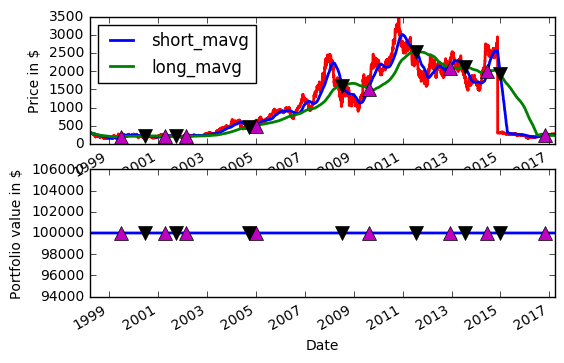

In [6]:
if __name__ == "__main__":
    #taking data from quandl using API call
    symbol = 'SBIN'
    bars = quandl.get("NSE/SBIN")

    # Create a Moving Average Cross Strategy instance with a short moving
    # average window of 100 days and a long window of 400 days
    mac = MovingAverageCrossStrategy(symbol, bars, short_window=100, long_window=400)
    signals = mac.generate_signals()

    # Create a portfolio of SBIN, with $100,000 initial capital
    portfolio = MarketOnClosePortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()

    # Plot two charts to assess trades and equity curve
    fig = plt.figure()
    fig.patch.set_facecolor('white')     # Set the outer colour to white
    ax1 = fig.add_subplot(211,  ylabel='Price in $')
    
    # Plot the AAPL closing price overlaid with the moving averages
    bars['Close'].plot(ax=ax1, color='r', lw=2.)
    signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the "buy" trades against SBIN
    ax1.plot(signals.ix[signals.positions == 1.0].index, 
             signals.short_mavg[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the "sell" trades against AAPL
    ax1.plot(signals.ix[signals.positions == -1.0].index, 
             signals.short_mavg[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the equity curve in dollars
    ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
    returns['total'].plot(ax=ax2, lw=2.)

    # Plot the "buy" and "sell" trades against the equity curve
    ax2.plot(returns.ix[signals.positions == 1.0].index, 
             returns.total[signals.positions == 1.0],
             '^', markersize=10, color='m')
    ax2.plot(returns.ix[signals.positions == -1.0].index, 
             returns.total[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the figure
    plt.show()